In [309]:
import numpy as np
import skimage
from skimage import transform
from skimage import io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import random
from PIL import Image

In [310]:

def get_sift(img):
    """
    detect the keypoints and compute their SIFT descriptors from opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, distance = sift.detectAndCompute(img, None)
    return kp, distance


def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    ax: plot handle
    img1: left image
    img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

In [312]:
##############################################
### Provided code - nothing to change here ###
##############################################



"""
Harris Corner Detector
Usage: Call the function harris(filename) for corner detection
Reference   (Code adapted from):
             http://www.kaij.org/blog/?p=89
             Kai Jiang - Harris Corner Detector in Python
             
"""
# Usage: 
#harris('./path/to/image.jpg')


def harris(im, min_distance = 10, threshold = 0.1):
    """
    filename: Path of image file
    threshold: (optional)Threshold for corner detection
    min_distance : (optional)Minimum number of pixels separating 
     corners and image boundary
     returns: filtered_coords list. index zero is row and index 1 is columns.
    """
    harrisim = compute_harris_response(im)
    filtered_coords = get_harris_points(harrisim,min_distance, threshold)
    plot_harris_points(im, filtered_coords)
    return filtered_coords

def gauss_derivative_kernels(size, sizey=None):
    """ returns x and y derivatives of a 2D 
        gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    y, x = mgrid[-size:size+1, -sizey:sizey+1]
    #x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    return gx,gy

def gauss_kernel(size, sizey = None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def compute_harris_response(im):
    """ compute the Harris corner detector response function 
        for each pixel in the image"""
    #derivatives
    gx,gy = gauss_derivative_kernels(3)
    imx = signal.convolve(im,gx, mode='same')
    imy = signal.convolve(im,gy, mode='same')
    #kernel for blurring
    gauss = gauss_kernel(3)
    #compute components of the structure tensor
    Wxx = signal.convolve(imx*imx,gauss, mode='same')
    Wxy = signal.convolve(imx*imy,gauss, mode='same')
    Wyy = signal.convolve(imy*imy,gauss, mode='same')   
    #determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy   
    return Wdet / Wtr

def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    """ return corners from a Harris response image
        min_distance is the minimum nbr of pixels separating 
        corners and image boundary"""
    #find top corner candidates above a threshold
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
    #sort candidates
    index = argsort(candidate_values)   
    #store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
    return filtered_coords

def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
    axis('off')
    show()

##############################################
### Provided code end                      ###
##############################################

# Your implementations

In [ ]:


def get_matches(img1, img2, percentile):
    kpoint1, dis1 = get_sift(img1)
    kpoint2, dis2 = get_sift(img2)
    kpoint1, kpoint2 = np.array(kpoint1), np.array(kpoint2)
    
    dist = scipy.spatial.distance.cdist(dis1, dis2, 'sqeuclidean') 
    
    # Flatten the matrix and find the N-th percentile value
    threshold = np.percentile(dist, percentile)
    print(f"threshold is = {threshold}")

    # Get the indices of elements below the percentile
    indices = np.argwhere(dist < threshold)
    print(f"num of matches allowed {indices.shape}")

    # get putative under distance distances 
    matches = []
    new_matches= []
    h,w = dist.shape
    for i in range(h):
        for j in range(w):
            if dist[i][j] <= 10000:
                new_matches = list(kpoint1[i].pt+kpoint2[j].pt)
                matches.append(new_matches)
    matches = np.array(matches)

    print(f"num matches {matches.shape}")
    return matches
    
def get_residual(H, data):
    count = len(data)
    point1 = np.hstack((data[:,:2],np.ones(( count,1))))
    point2 = data[:,2:]
                
    est = np.zeros((count,2))
    for i in range(count):
        # x, y = x/w, y/w 
        tmp = np.dot(H,point1[i])/np.dot(H,point1[i])[-1]
        est[i] = tmp[:2]
    
    residual = np.linalg.norm(point2 - est, axis=1) ** 2
    
    return residual
        


def ransac(data, t, req_inliers, iterations=1000):
    best_H = None
    best_inliers = None
    max_inliers = 0
    best_residual = float('inf')

    for i in range(iterations):
        sub_index = np.random.choice(len(data), 4)
        subset = data[sub_index]
        
        #get homography
        A = []
        for i in range(4):
            point1 = np.append(subset[i][:2],1)
            point2 = np.append(subset[i][2:],1)
            
            coord1 = [0,0,0,point1[0],point1[1],point1[2],-point2[1]*point1[0],-point2[1]*point1[1],-point2[1]*point1[2]]
            coord2 = [point1[0],point1[1],point1[2],0,0,0,-point2[0]*point1[0],-point2[0]*point1[1],-point2[0]*point1[2]]
            A.append(coord1)
            A.append(coord2)

        #SVD    
        A = np.array(A)
        _, _, V = np.linalg.svd(A)
        H = V[-1,:].reshape((3,3))
        
        #this is homography transformation 
        H = H/H[2,2]
        
        if np.linalg.matrix_rank(H) < 3:
            #H is degenerate 
            continue

        # Get inliers
        errors = get_residual(H, data)
        index = np.where(errors < t)[0]
        inliers = data[index]
        
        #  update the model if inliers more than required
        if len(inliers) >= req_inliers and len(inliers) >= max_inliers:
            curr_err = errors[index].sum() / len(inliers)
            if len(inliers) == max_inliers:
                # check the residual
                if curr_err > best_residual:  
                    continue
            
            best_residual = errors[index].sum() / len(inliers)
            best_inliers = inliers.copy()
            best_H = H.copy()
            max_inliers = len(inliers)
                
    return best_H, best_inliers, max_inliers, best_residual


    

In [314]:
import numpy as np
from skimage.transform import ProjectiveTransform, warp
from skimage import io

def warp_images(img1, img2, H):
    """
    Warp the right image onto the left image using the provided homography matrix.

    Args:
    - left_image: left color image.
    - right_image: right color image.
    - homography_matrix (numpy.array): 3x3 homography transformation matrix.

    Returns:
    - The composite panorama image.
    """
    transform = ProjectiveTransform(H)
    
    # Calculate the boundary of warped image
    h, w, z = img1.shape
    raw = np.array([[0, 0], [0, h], [w, h], [w, 0]])
    trans = transform(raw)
    combine = np.vstack((raw, trans))
    min_dot = np.int32(combine.min(axis=0))
    max_dot = np.int32(combine.max(axis=0))
    offset_x = -min_dot[0]
    offset_y = -min_dot[1]
    print("offset is ", (offset_x, offset_y))
    T_matrix = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]])
    match = cv2.warpPerspective(img2, T_matrix.dot(H), tuple(max_dot - min_dot))
    h1, w1, z1 = match.shape
    
    for y in range(h):
        for x in range(w):
            if offset_x + x < w1 and offset_y + y < h1:
                if np.count_nonzero(match[offset_y + y, offset_x + x]) == 0:
                    match[offset_y + y, offset_x + x] = img1[y, x]
                else:
                    match[offset_y + y, offset_x + x] = (match[offset_y + y, offset_x + x]).astype(np.uint8)
    return match


# Main functions

In [315]:
# load images

img1 = np.array(Image.open('Images/left.jpg'))
img2 = np.array(Image.open('Images/right.jpg'))

gray1 = Image.open('Images/left.jpg').convert("L")
gray2 = Image.open('Images/right.jpg').convert("L")
gray1 = cv2.cvtColor(np.array(gray1), cv2.COLOR_GRAY2BGR)
gray2 = cv2.cvtColor(np.array(gray2), cv2.COLOR_GRAY2BGR)


In [ ]:
# compute and display the initial SIFT matching result
data = get_matches(gray1, gray2, percentile=1)


threshold is = 139373.71
num of matches allowed (153575, 2)
num matches (61, 4)


Average residual: 32.90053752281749
Inliers: 43


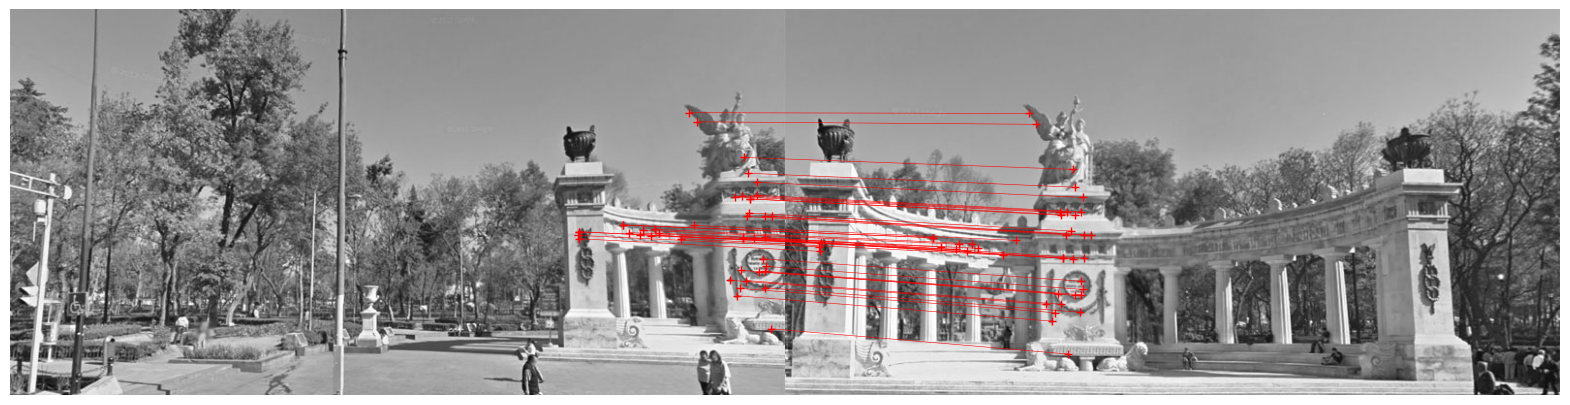

In [317]:
# part (d) performn RANSAC to get the homography and inliers, 
# display the inlier matching, report the average residual

H, ransac_match, best_inliers, best_model_errors = ransac(data, 100, 15)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", best_inliers)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, gray1, gray2, ransac_match)
fig.savefig('ransac_match.pdf', bbox_inches='tight')


In [318]:
H.shape

(3, 3)

offset is  (0, 0)


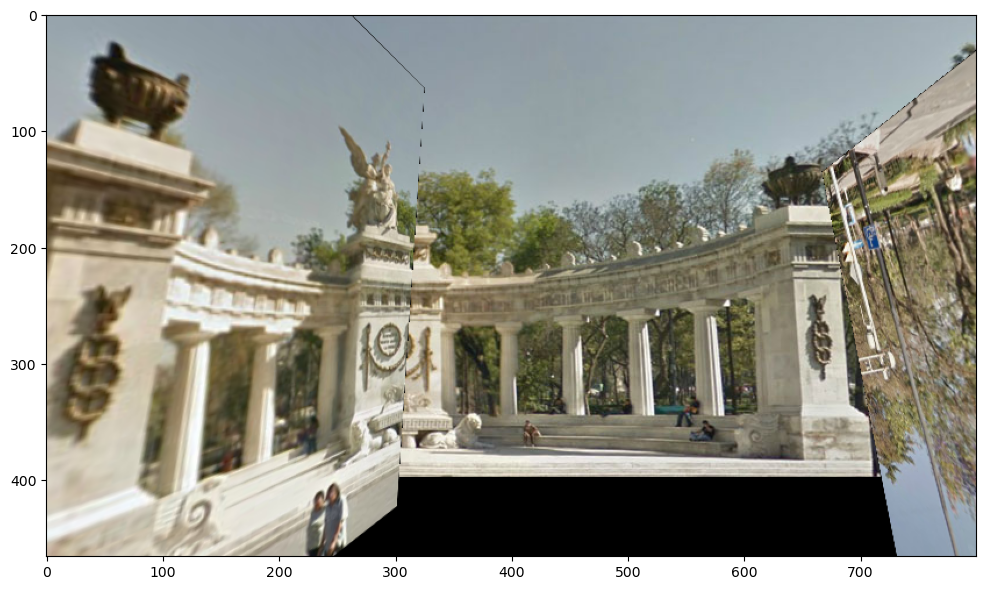

offset is  (0, 0)


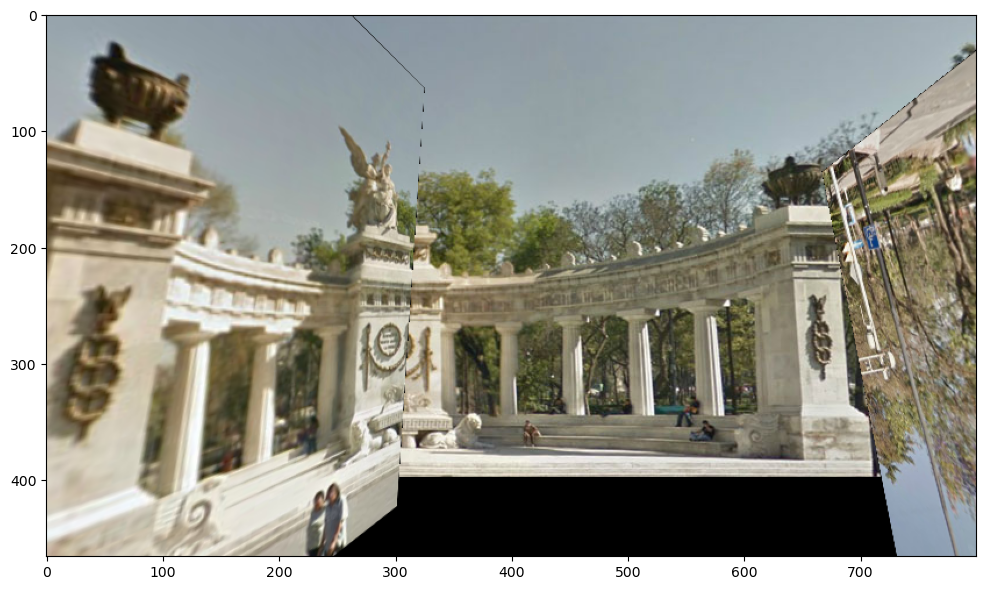

In [ ]:
# part (e) warp images to stitch them together, 
# display and report the stitching results

im = warp_images(img2, img1, H)

plt.figure(figsize=(12, 8))
plt.imshow(im)
plt.show()

im = Image.fromarray(im)
im.save("two_image.jpg", format="jpeg")
